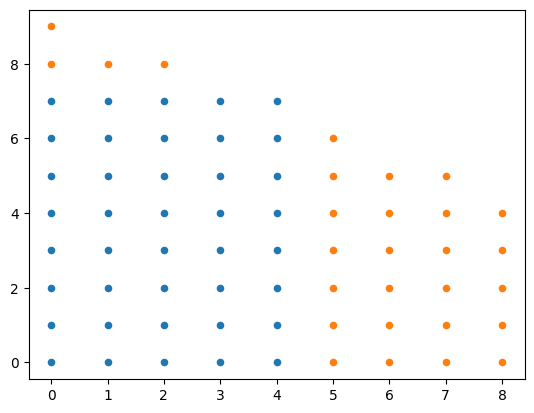

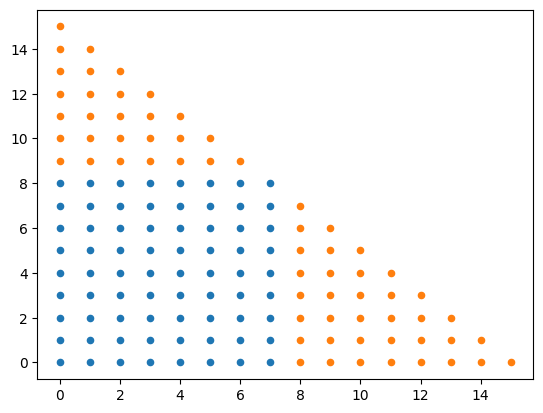

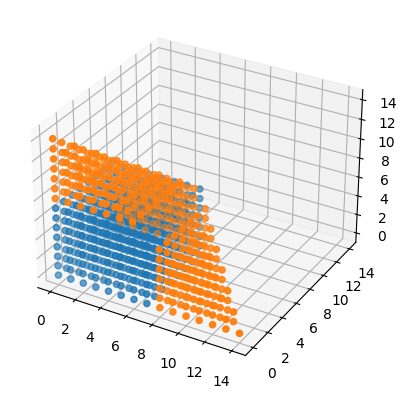

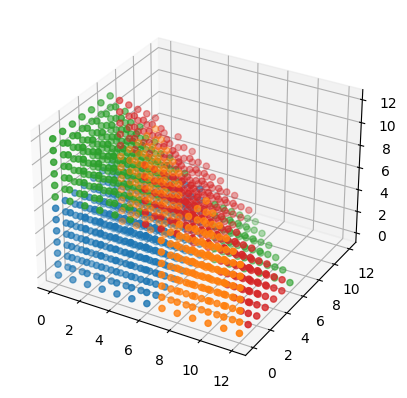

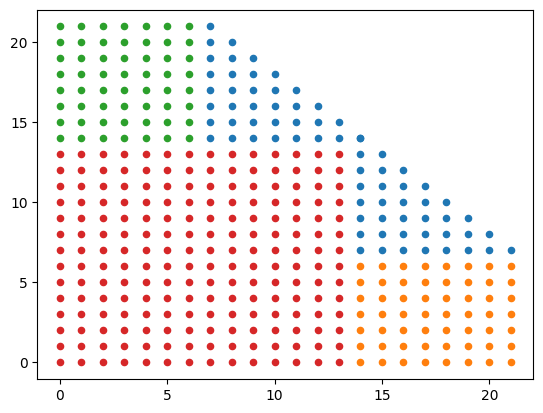

In [1]:
# Comments about figure refer to the paper "BRAVAIS LATTICES FOR EUCLIDEAN DEGREE EFFICIENT
# POLYNOMIAL INTERPOLATION"
# Reproduces figure 2.4, right side

import numpy as np
import matplotlib.pyplot as plt
import test
#%matplotlib tk

import ilfft_interp
# Example to plot the bases of the example lattices. Each point in the graph represent
# A chebyshev basis function

#One quadrant of a (nearly) regular hexagon
U = ilfft_interp.HexLattice(2)
U.plot_basis()

#One quadrant of the L_1 ball in 2d
U = ilfft_interp.PadLattice(16)
U.plot_basis()

#one quadrant of a rhombic dodecahedron, which is a stellation of an octahedron
U = ilfft_interp.BCCLattice(7)
U.plot_basis()

#one quadrant of a truncated octahedron
U = ilfft_interp.FCCLattice(6)
U.plot_basis()

U = ilfft_interp.OctLattice(8)
U.plot_basis()

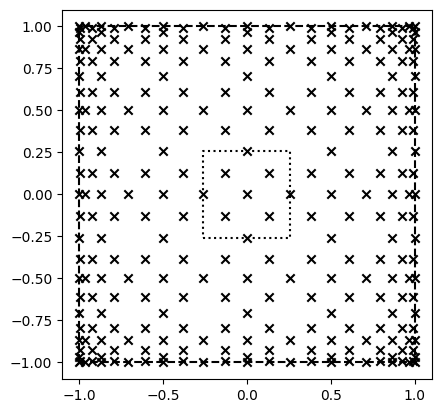

In [7]:
# Reproduces figure 2.4, left side

U = ilfft_interp.OctLattice(7)
p = U.get_points()

a = np.sin(np.pi/12)
plt.scatter(p[:, 0], p[:, 1], c = 'k', marker='x')
plt.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k--')
plt.plot(a*np.array([-1, 1, 1, -1, -1]), a*np.array([-1, -1, 1, 1, -1]), 'k:')
plt.gca().set_aspect('equal')
plt.show()

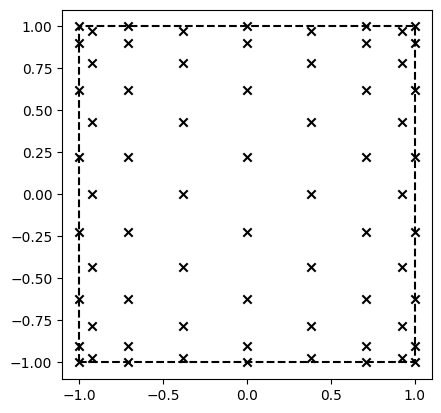

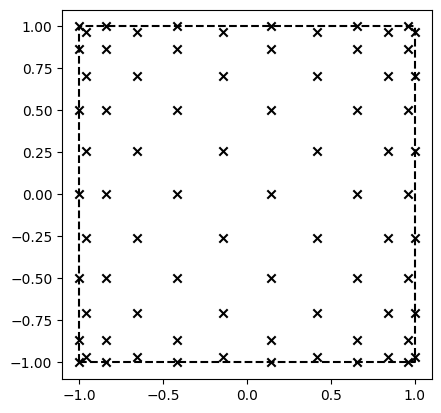

In [11]:
# Reproduction for figure 3.1 center and right. 3.1 left is a standard 9x9 Chebyshev grid.
U = ilfft_interp.HexLattice(2)
p = U.get_points()

plt.scatter(p[:, 0], p[:, 1], c = 'k', marker='x')
plt.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k--')
plt.gca().set_aspect('equal')
plt.show()

U = ilfft_interp.PadLattice(12)
p = U.get_points()

plt.scatter(-p[:, 0], p[:, 1], c = 'k', marker='x')
plt.plot([-1, 1, 1, -1, -1], [-1, -1, 1, 1, -1], 'k--')
plt.gca().set_aspect('equal')
plt.show()

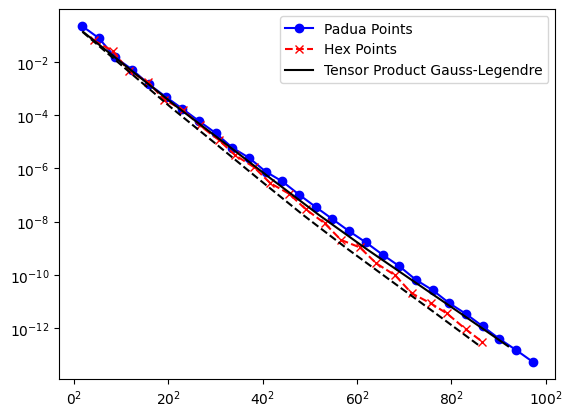

In [12]:
# Reproduces figure 5.2 bottom.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.scale import FuncScale
import test
from scipy.special import roots_legendre
import ilfft_interp as bf
import mod_fejer as mf
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#%matplotlib tk

# Compare integration accuracy of the Padua and Hex lattices as well as Gauss-Legendre quadrature.
# Hex performs best in some middling resolution regimes, but GL is safer.
x_0 = -.2
y_0 = .0
leg_res = 400
x, w = roots_legendre(leg_res)
W = np.outer(w, w)
X, Y = np.meshgrid(x, x)
t_res = 600
t = np.linspace(0, 2*np.pi, t_res)[:-1]

f = lambda x, y, theta: 1/(1 + 50*((np.cos(theta)*x + np.sin(theta)*y - x_0)**2 + (np.cos(theta)*y - np.sin(theta)*x - y_0)**2))
I = [np.sum(f(X, Y, theta)*W) for theta in t]

pad_pcount = []
pad_error  = []
for i in range(2, 140, 5):
    U = bf.PadLattice(i)
    val = 0
    for j, theta in enumerate(t):
        U.eval_func(lambda x, y: f(x, y, theta))
        val += np.abs(I[j] - U.get_integral())/t_res
    pad_pcount.append(U.get_point_count())
    pad_error.append(val)
    
hex_pcount = []
hex_error  = []
for i in range(1, 24):
    val = 0
    U = bf.HexLattice(i)
    for j, theta in enumerate(t):
        U.eval_func(lambda x, y: f(x, y, theta))
        val += np.abs(I[j] - U.get_integral())/t_res
    hex_pcount.append(U.get_point_count())
    hex_error.append(val)

mf_pcount = []
mf_error  = []
for i in range(1, 20):
    U = mf.mod_fejer_hex(i)
    val = 0
    for j, theta in enumerate(t):
        val += np.abs(I[j] - np.sum(U.stencil*(f(U.X, U.Y, theta))))/t_res
    mf_pcount.append(U.get_point_count())
    mf_error.append(val)
    
leg_pcount = []
leg_error  = []
for i in range(2, 100, 10):
    x, w = roots_legendre(i)
    W = np.outer(w, w)
    val = 0
    X, Y = np.meshgrid(x, x)
    for j, theta in enumerate(t):
        val += np.abs(I[j] - np.sum(f(X, Y, theta)*W))/t_res
    leg_pcount.append(i**2)
    leg_error.append(val)
    
plt.semilogy(np.sqrt(np.array(pad_pcount)), pad_error, 'b-o')
plt.semilogy(np.sqrt(np.array(hex_pcount)), hex_error, 'r--x')
#plt.semilogy(np.sqrt(np.array(mf_pcount)), mf_error)
plt.semilogy(np.sqrt(np.array(leg_pcount)), leg_error, 'k-')
plt.semilogy(np.sqrt((7/8)*np.array(leg_pcount)), leg_error, 'k--')
#plt.xscale("function", functions=(lambda x: np.sqrt(x), lambda x: x**2))
#plt.xticks([100, 400, 1600, 3600, 6400, 10000, 14400])
plt.legend(["Padua Points", "Hex Points", "Tensor Product Gauss-Legendre"])
plt.gca().xaxis.set_major_formatter('${x:.0f}^2$')
plt.show()

In [13]:
# Produces the data for figure 5.2 top. Takes time to run.
# The data is produced using randomly oriented functions, but should be mostly consistent

import numpy as np
import numpy.linalg as lin
from numpy.random import normal
import matplotlib.pyplot as plt
import test
from scipy.special import roots_legendre
import ilfft_interp as bf
#%matplotlib tk

# Compare integration accuracy of the BCC and FCC lattices as well as Gauss-Legendre quadrature.
compiled_results = []

rot_list = []
N = 20
for i in range(N):
    #Draw a set of three random orthogonal unit vectors
    M = normal(size=(3,3))
    M[0] /= lin.norm(M[0])
    M[1] -= (M[0] @ M[1])*M[0]
    M[1] /= lin.norm(M[1])
    M[2] -= (M[0] @ M[2])*M[0]
    M[2] -= (M[1] @ M[2])*M[1]
    M[2] /= lin.norm(M[2])
    rot_list.append(M)

def xyz_transform(x, y, z, m):
    return tuple([x*v[0] + y*v[1] + z*v[2] for v in m])
    
x_0 = -.3
y_0 = .0
z_0 = .0
leg_res = 90
x, w = roots_legendre(leg_res)
W = np.einsum("i, j, k", w, w, w)
X, Y, Z = np.meshgrid(x, x, x)

func_list = [lambda x, y, z: np.exp(-(45*(x_0 - x)**2 + 45*(y_0 - y)**2 + 45*(z_0 - z)**2)),
             lambda x, y, z: 1/(1 + (30*(x_0 - x)**2 + 30*(y_0 - y)**2 + 30*(z_0 - z)**2)),
            # lambda x, y, z: np.exp(-1/(25*(x_0 - x)**2 + 25*(y_0 - y)**2 + 25*(z_0 - z)**2))
            ]

for f in func_list:
    
    #f = lambda x, y, z: 1/(1 + (25*(x_0 - x)**2 + 25*(y_0 - y)**2 + 25*(z_0 - z)**2))
    I = [np.sum(f(*xyz_transform(X, Y, Z, M))*W) for M in rot_list]
    compiled_results.append(dict())

    BCC_pcount = []
    BCC_error  = []
    for i in range(1, 50, 1):
        #print(i)
        U = bf.BCCLattice(i)
        tmp_err = []
        for j, m in enumerate(rot_list):
            f_tmp = lambda x, y, z: f(*xyz_transform(x, y, z, m))
            U.eval_func(f_tmp)
            tmp_err.append(np.abs(I[j] - U.get_integral())/N)

        BCC_pcount.append(U.get_point_count())
        BCC_error.append(np.sum(tmp_err))

    FCC_pcount = []
    FCC_error  = []
    for i in range(1, 50, 1):
        #print(i)
        U = bf.FCCLattice(i)
        tmp_err = []
        for j, m in enumerate(rot_list):
            f_tmp = lambda x, y, z: f(*xyz_transform(x, y, z, m))
            U.eval_func(f_tmp)
            tmp_err.append(np.abs(I[j] - U.get_integral())/N)

        FCC_pcount.append(U.get_point_count())
        FCC_error.append(np.sum(tmp_err))

    leg_pcount = []
    leg_error  = []
    for i in range(2, 73, 4):
        #print(i)
        x, w = roots_legendre(i)
        W = np.einsum("i,j,k", w, w, w)
        X, Y, Z = np.meshgrid(x, x, x)
        tmp_err = []
        for j, m in enumerate(rot_list):
            f_tmp = lambda x, y, z: f(*xyz_transform(x, y, z, m))
            tmp_err.append(np.abs(I[j] - np.sum(f_tmp(X, Y, Z)*W))/N)
        leg_pcount.append(i**3)
        leg_error.append(np.sum(tmp_err))
    compiled_results[-1]['bp'] = BCC_pcount
    compiled_results[-1]['be'] = BCC_error
    compiled_results[-1]['fp'] = FCC_pcount
    compiled_results[-1]['fe'] = FCC_error
    compiled_results[-1]['lp'] = leg_pcount
    compiled_results[-1]['le'] = leg_error
    
plt.semilogy((np.array(BCC_pcount))**(1/3), BCC_error)
plt.semilogy((np.array(FCC_pcount))**(1/3), FCC_error)
plt.semilogy((np.array(leg_pcount))**(1/3), leg_error)
plt.show()

In [14]:
#Produces the plots for figure 5.2. Cell above must be run first.

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(2):
    ax[i].semilogy((np.array(compiled_results[i]['bp']))**(1/3), compiled_results[i]['be'], 'm-s')
    ax[i].semilogy((np.array(compiled_results[i]['fp']))**(1/3), compiled_results[i]['fe'], 'b-x')
    ax[i].semilogy((np.array(compiled_results[i]['lp']))**(1/3), compiled_results[i]['le'], 'k-')
    ax[i].semilogy((.71*np.array(compiled_results[i]['lp']))**(1/3), compiled_results[i]['le'], 'k--')
    if i == 0:
        ax[i].legend(["BCC points", "FCC Points", "Gauss-Legendre"])
    ax[i].xaxis.set_major_formatter('${x:.0f}^3$')
    
plt.show()

In [4]:
import numpy as np
import numpy.linalg as lin
import ilfft_interp as bf
import matplotlib.pyplot as plt
#%matplotlib tk

x_0 = .1
y_0 = .2
f  = lambda x, y: 1/(1 + 25*(x_0 - x)**2 + 25*(y_0 - y)**2)
df = lambda x, y: -50*(x - x_0)/(1 + 25*(x_0 - x)**2 + 25*(y_0 - y)**2)**2

def cheb_diff(N, f, df):
    c = lambda i: 1 + ((i == 0) or (i == N))
    D = np.zeros((N + 1, N + 1))
    x = bf.cheby_points(N + 1)
    for i in range(N + 1):
        D[i,i] = -x[i]/(2*(1 - x[i]**2)) if (i != 0) and (i != N) else ((-1)**(i != 0))*(2*N**2 + 1)/6
        for j in range(i):
            D[i, j] = (c(i)/c(j))*((-1)**(i + j))/(x[i] - x[j])
            D[j, i] = (c(j)/c(i))*((-1)**(i + j))/(x[j] - x[i])
    X, Y = np.meshgrid(x, x)
    Z = f(X, Y)
    for i in range(N + 1):
        Z[i] = D @ Z[i]
    Z -= df(X, Y)
    return Z

cheb_pcount = []
cheb_error  = []
for i in range(2, 200):
    Z = cheb_diff(i, f, df)
    Z[...] = Z**2
    Z *= 4/(i**2)
    Z[0] *= .5
    Z[-1] *= .5
    Z[:, 0] *= .5
    Z[:, -1] *= .5
    cheb_pcount.append((i + 1)**2)
    cheb_error.append(np.sqrt(np.sum(Z)))

hex_pcount = []
hex_error = []
for i in range(1, 50):
    #print(i)
    U = bf.HexLattice(i)
    U.eval_func(f)
    U.transform()
    U.get_deriv(0)
    U.inverse_transform()
    g = [L.copy() for L in U.grids]
    U.eval_func(df)
    for i in range(len(U.grids)):
        U.grids[i] -= g[i]
        U.grids[i][...] = U.grids[i]**2
    U.apply_chebyshev_weights()
    hex_pcount.append(U.get_point_count())
    hex_error.append(np.sqrt(sum([np.sum(L) for L in U.grids])))

pad_pcount = []
pad_error = []
for i in range(2, 200, 5):
    #print(i)
    U = bf.PadLattice(i)
    U.eval_func(f)
    U.transform()
    U.get_deriv(0)
    U.inverse_transform()
    g = [L.copy() for L in U.grids]
    U.eval_func(df)
    for i in range(len(U.grids)):
        U.grids[i] -= g[i]
        U.grids[i][...] = U.grids[i]**2
    U.apply_chebyshev_weights()
    pad_pcount.append(U.get_point_count())
    pad_error.append(np.sqrt(sum([np.sum(L) for L in U.grids])))

plt.semilogy(np.sqrt(np.array(cheb_pcount)), cheb_error)
plt.semilogy(np.sqrt(np.array(hex_pcount)), hex_error)
plt.semilogy(np.sqrt(np.array(pad_pcount)), pad_error)
plt.show()

In [4]:
# Three Dimensional L2 error
# Produces data for the top plots of figure 5.3

import numpy as np
import numpy.linalg as lin
import ilfft_interp as bf
import matplotlib.pyplot as plt
import scipy.fft as fft
from numpy.random import normal
#%matplotlib tk

class results_3d:
    def __init__(self, fp, fe, cp, ce, bp, be):
        self.fp = fp
        self.fe = fe
        self.cp = cp
        self.ce = ce
        self.bp = bp
        self.be = be

V = bf.BCCLattice(60)
rot_list = []
N = 30
for i in range(N):
    #Draw a set of three random orthogonal unit vectors
    M = normal(size=(3,3))
    M[0] /= lin.norm(M[0])
    M[1] -= (M[0] @ M[1])*M[0]
    M[1] /= lin.norm(M[1])
    M[2] -= (M[0] @ M[2])*M[0]
    M[2] -= (M[1] @ M[2])*M[1]
    M[2] /= lin.norm(M[2])
    rot_list.append(M)

def xyz_transform(x, y, z, m):
    return tuple([x*v[0] + y*v[1] + z*v[2] for v in m])
    
x_0 = -.15
y_0 = .15
z_0 = .0
f_list = [ lambda x, y, z: np.exp(-3*(x_0 - x)**2 - y**2 - z**2),
    lambda x, y, z: 1/(1 + 3*((x_0 - x)**2 + (y_0 - y)**2 + (z_0 - z)**2)),
    lambda x, y, z: np.exp(-2/((x_0 - x)**2 + (y-y_0)**2 + z**2))
         ]
r_list = []
for f_i, f in enumerate(f_list):
    val_list = []
    for M in rot_list:
        V.eval_func(lambda x,y,z: f(*xyz_transform(x, y, z, M)))
        val_list.append((V.grids[0].copy(), V.grids[1].copy()))


    BCC_pcount = []
    BCC_error  = []
    for i in range(2, 20):
        #print(i)
        U = bf.BCCLattice(i)
        tmp_err = []
        for j, M in enumerate(rot_list):
            f_tmp = lambda x, y, z: f(*xyz_transform(x, y, z, M))
            U.eval_func(f_tmp)
            U.transform()
            c = U.to_cartesian()
            V.coefs[0][...] = 0
            V.coefs[1][...] = 0
            V.coefs[0][:c.shape[0], :c.shape[1], :c.shape[2]] = c
            V.inverse_transform()
            V.grids[0][...] = (V.grids[0] - val_list[j][0])**2
            V.grids[1][...] = (V.grids[1] - val_list[j][1])**2
            tmp_err.append(np.sqrt(V.get_integral())/N)
        
        BCC_pcount.append(U.get_point_count())
        BCC_error.append(np.sum(tmp_err))

    FCC_error  = []
    FCC_pcount = []
    coef_check = []
    coef_list = []
    for i in range(2, 18):
        #print(i)
        U = bf.FCCLattice(i)
        tmp_err = []
        for j, M in enumerate(rot_list):
            f_tmp = lambda x, y, z: f(*xyz_transform(x, y, z, M))
            U.eval_func(f_tmp)
            U.transform()
            c = U.to_cartesian()
            V.coefs[0][...] = 0
            V.coefs[1][...] = 0
            V.coefs[0][:c.shape[0], :c.shape[1], :c.shape[2]] = c
            V.inverse_transform()
            V.grids[0][...] = (V.grids[0] - val_list[j][0])**2
            V.grids[1][...] = (V.grids[1] - val_list[j][1])**2
            tmp_err.append(np.sqrt(V.get_integral())/N)
            V.grids[0][...] = val_list[j][0]
            V.grids[1][...] = val_list[j][1]
            V.transform()
        
        
        FCC_pcount.append(U.get_point_count())
        FCC_error.append(np.sum(tmp_err))   

    cart_err = []
    cart_pcount = []
    for i in range(2, 30, 3):
        #print(i)
        x = bf.cheby_points(i)
        X, Y, Z = np.meshgrid(x, x, x, indexing='ij')
        tmp_err = []
        for j, M in enumerate(rot_list):
            f_tmp = lambda x, y, z: f(*xyz_transform(x, y, z, M))
            F = f_tmp(X, Y, Z)
            c = fft.dctn(F, type=1)/((F.shape[0] - 1)**3)
            c[0,...] /= 2
            c[:,0,:] /= 2
            c[:,:,0] /= 2
            c[-1,...] /= 2
            c[:,-1,:] /= 2
            c[...,-1] /= 2
            V.coefs[0][...] = 0
            V.coefs[1][...] = 0
            V.coefs[0][:c.shape[0], :c.shape[1], :c.shape[2]] = c
            V.inverse_transform()
            V.grids[0][...] = (V.grids[0] - val_list[j][0])**2
            V.grids[1][...] = (V.grids[1] - val_list[j][1])**2
            tmp_err.append(np.sqrt(V.get_integral())/N)
        
        cart_pcount.append(i**3)
        cart_err.append(np.sum(tmp_err))
    
    
    r_list.append(results_3d(FCC_pcount, FCC_error, cart_pcount, cart_err, BCC_pcount, BCC_error))

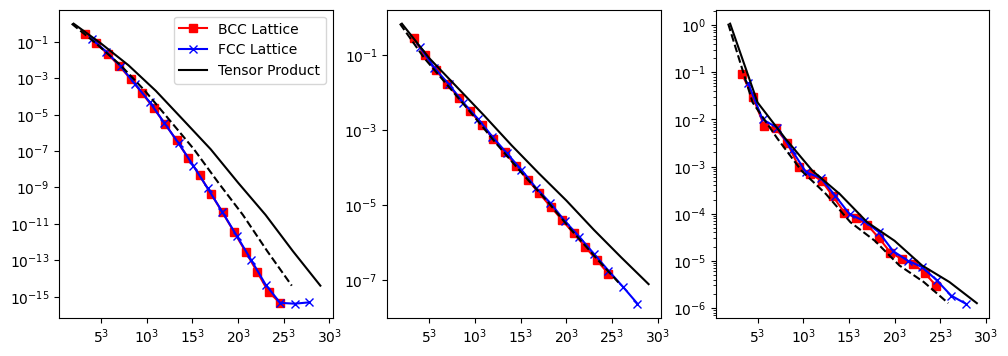

In [6]:
#Produces top plots for figure 5.3. Requires above cell to provide data.


#plt.semilogy((np.array(r.bp))**(1/3), r.be, 'r-o')
#plt.semilogy((np.array(r.fp))**(1/3), r.fe, 'b-o')
#plt.semilogy((np.array(r.cp))**(1/3), r.ce, 'k-')
#plt.semilogy((.71*np.array(r.cp))**(1/3), r.ce, 'k--')
#plt.legend(["BCC Points", "FCC Points", "Tensor Product", "Theoretical BCC"])
#plt.gca().xaxis.set_major_formatter('${x:.0f}^3$')
#plt.show()
#plt.show()
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    ax[i].semilogy((np.array(r_list[i].bp))**(1/3), r_list[i].be, 'r-s')
    ax[i].semilogy((np.array(r_list[i].fp))**(1/3), r_list[i].fe, 'b-x')
    ax[i].semilogy((np.array(r_list[i].cp))**(1/3), r_list[i].ce, 'k-')
    ax[i].semilogy(((.71)*np.array(r_list[i].cp))**(1/3), r_list[i].ce, 'k--')
    if i == 0:
        ax[i].legend(["BCC Lattice", "FCC Lattice", "Tensor Product"])
    ax[i].xaxis.set_major_formatter('${x:.0f}^3$')
    
plt.show()

In [8]:
#Produces the data for Figure 5.3 Bottom. L_2 error for 2d lattices
import numpy as np
import numpy.linalg as lin
import ilfft_interp as bf
import matplotlib.pyplot as plt
import scipy.fft as fft
from numpy.random import normal
#%matplotlib tk

class results_storage:
    def __init__(self, pp, pe, cp, ce, op, oe, hp, he):
        self.pp = pp
        self.pe = pe
        self.cp = cp
        self.ce = ce
        self.op = op
        self.oe = oe
        self.hp = hp
        self.he = he
rs = []
func_list = []
func_names = []
x_0 = -.2
y_0 = .0
z_0 = .0
func_list.append(lambda x, y:np.cos(1 - (12*(x_0 - x) + 12*(y_0 - y))) + np.sin(1 - (12*x - 12*y)))
func_names.append("Entire")
func_list.append(lambda x, y:1/((2*(2.3 - x) + 2*(y_0 - y))))
func_names.append("Analytic")
func_list.append(lambda x, y: 10*np.exp(-1/(.1*(x_0 - x)**2 + .1*(y_0 - y)**2)))
func_names.append("$C_\infty$")
                 
for f in func_list:
    V = bf.PadLattice(300)
    rot_list = []
    N = 60
    for t in np.linspace(0, 2*np.pi, N)[:-1]:
        #Draw a set of three random orthogonal unit vectors
        M = np.array([[np.cos(t), np.sin(t)],[-np.sin(t), np.cos(t)]])
        rot_list.append(M)

    def xyz_transform(x, y, m):
        return tuple([x*v[0] + y*v[1] for v in m])


    val_list = []
    l2_norms = []
    for M in rot_list:
        V.eval_func(lambda x,y: f(*xyz_transform(x, y, M)))
        val_list.append((V.grids[0].copy(), V.grids[1].copy()))
        V.grids[0][...] = V.grids[0]**2
        V.grids[1][...] = V.grids[1]**2
        l2_norms.append(np.sqrt(V.get_integral()))


    pad_pcount = []
    pad_error  = []
    for i in range(20, 70, 4):
        #print(i)
        U = bf.PadLattice(i)
        tmp_err = []
        for j, M in enumerate(rot_list):
            f_tmp = lambda x, y: f(*xyz_transform(x, y, M))
            U.eval_func(f_tmp)
            U.transform()
            c = U.to_cartesian()
            V.coefs[0][...] = 0
            V.coefs[1][...] = 0
            V.coefs[0][:c.shape[0], :c.shape[1]] = c
            V.inverse_transform()
            V.grids[0][...] = (V.grids[0] - val_list[j][0])**2
            V.grids[1][...] = (V.grids[1] - val_list[j][1])**2
            tmp_err.append(np.sqrt(V.get_integral())/(N*l2_norms[j]))
        
        pad_pcount.append(U.get_point_count())
        pad_error.append(np.sum(tmp_err))
    
    cart_err = []
    cart_pcount = []
    for i in range(15, 50, 3):
        #print(i)
        x = bf.cheby_points(i)
        X, Y = np.meshgrid(x, x, indexing='ij')
        tmp_err = []
        for j, M in enumerate(rot_list):
            f_tmp = lambda x, y: f(*xyz_transform(x, y, M))
            F = f_tmp(X, Y)
            c = fft.dctn(F, type=1)/((F.shape[0] - 1)**2)
            c[0,...] /= 2
            c[:,0] /= 2
            c[-1,...] /= 2
            c[:,-1] /= 2
            V.coefs[0][...] = 0
            V.coefs[1][...] = 0
            V.coefs[0][:c.shape[0], :c.shape[1]] = c
            V.inverse_transform()
            V.grids[0][...] = (V.grids[0] - val_list[j][0])**2
            V.grids[1][...] = (V.grids[1] - val_list[j][1])**2
            tmp_err.append(np.sqrt(V.get_integral())/(N*l2_norms[j]))
        
        cart_pcount.append(i**2)
        cart_err.append(np.sum(tmp_err))

    hex_err = []
    hex_pcount = []
    for i in range(4, 12):
        #print(i)
        U = bf.HexLattice(i)
        tmp_err = []
        for j, M in enumerate(rot_list):
            f_tmp = lambda x, y: f(*xyz_transform(x, y, M))
            U.eval_func(f_tmp)
            U.transform()
            c = U.to_cartesian()
            V.coefs[0][...] = 0
            V.coefs[1][...] = 0
            V.coefs[0][:c.shape[0], :c.shape[1]] = c
            V.inverse_transform()
            V.grids[0][...] = (V.grids[0] - val_list[j][0])**2
            V.grids[1][...] = (V.grids[1] - val_list[j][1])**2
            tmp_err.append(np.sqrt(V.get_integral())/(N*l2_norms[j]))
        
        hex_pcount.append(U.get_point_count())
        hex_err.append(np.sum(tmp_err))

    oct_err = []
    oct_pcount = []
    for i in range(6, 18):
        #print(i)
        U = bf.OctLattice(i)
        tmp_err = []
        for j, M in enumerate(rot_list):
            f_tmp = lambda x, y: f(*xyz_transform(x, y, M))
            U.eval_func(f_tmp)
            U.transform()
            c = U.to_cartesian()
            V.coefs[0][...] = 0
            V.coefs[1][...] = 0
            V.coefs[0][:c.shape[0], :c.shape[1]] = c
            V.inverse_transform()
            V.grids[0][...] = (V.grids[0] - val_list[j][0])**2
            V.grids[1][...] = (V.grids[1] - val_list[j][1])**2
            tmp_err.append(np.sqrt(V.get_integral())/(N*l2_norms[j]))
        oct_pcount.append(U.get_point_count())
        oct_err.append(np.sum(tmp_err))
    rs.append(results_storage(pad_pcount, pad_error, cart_pcount, cart_err, oct_pcount, oct_err, hex_pcount, hex_err))


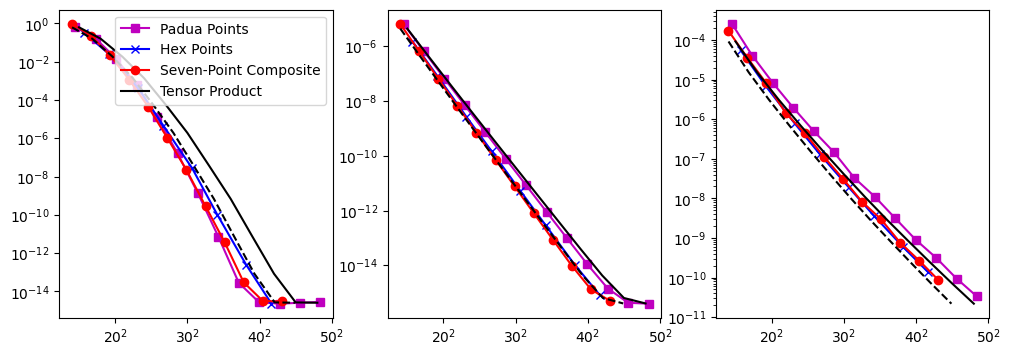

In [9]:
#Produces the plot for figure 5.3 bottom.
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    ax[i].semilogy((np.array(rs[i].pp))**(1/2), rs[i].pe, 'm-s')
    ax[i].semilogy((np.array(rs[i].hp))**(1/2), rs[i].he, 'b-x')
    ax[i].semilogy((np.array(rs[i].op))**(1/2), rs[i].oe, 'r-o')
    ax[i].semilogy((np.array(rs[i].cp))**(1/2), rs[i].ce, 'k-')
    ax[i].semilogy(((7/8)*np.array(rs[i].cp))**(1/2), rs[i].ce, 'k--')
    if i == 0:
        ax[i].legend(["Padua Points", "Hex Points", "Seven-Point Composite", "Tensor Product"])
    ax[i].xaxis.set_major_formatter('${x:.0f}^2$')
    
plt.show()

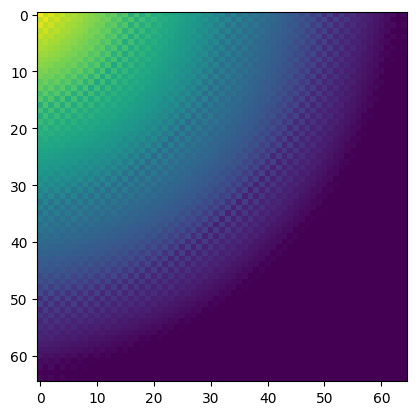

In [34]:
# Produces Figure 5.1, right plot
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft as fft
%matplotlib inline

#fig, axs = plt.subplots(1, 3)
theta = np.pi/4
N = 65
x = np.sin(np.linspace(-np.pi/2, np.pi/2, N))
X, Y = np.meshgrid(x, x)
f = lambda x: 1/(1 + 6*(x + .1)**2)
Z_avg = np.zeros(X.shape)
Z_hat = np.zeros(X.shape)
for theta in np.linspace(0, 2*np.pi, 300):
    Z = f(X*np.cos(theta) + Y*np.sin(theta))
    Z_hat = fft.dctn(Z,type=1)/np.prod(Z_hat.shape)
    Z_hat[0, :] /= np.sqrt(2)
    Z_hat[:, 0] /= np.sqrt(2)
    Z_avg += np.abs(Z_hat)**2/300
Z_avg = np.sqrt(Z_avg)
im = plt.imshow(np.maximum(np.log10(np.abs(Z_avg[::1, ::1])), -12))

/tmp/ipykernel_375515/3031221139.py:10: RuntimeWarning: divide by zero encountered in log10
  im = plt.imshow(np.maximum(np.log10(np.abs(Z_hat)), -12))


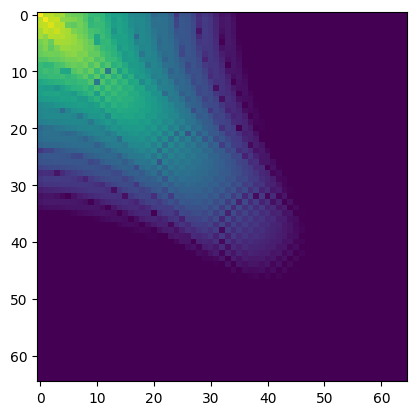

In [39]:
#Produces Figure 5.1 left (theta = pi/2) or center (theta = pi/4).
theta = np.pi/4
x = np.sin(np.linspace(-np.pi/2, np.pi/2, 65))
X, Y = np.meshgrid(x, x)
f = lambda x: 1/(1 + 6*(x+.1)**2)
Z = f(X*np.cos(theta) + Y*np.sin(theta))
Z_hat = fft.dctn(Z,type=1)/np.prod(Z_hat.shape)
Z_hat[0, :] /= np.sqrt(2)
Z_hat[:, 0] /= np.sqrt(2)
im = plt.imshow(np.maximum(np.log10(np.abs(Z_hat)), -12))